In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics
from scipy import stats

from copy import deepcopy

import h2o

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">🏡 House Pricing - EDA and Prediction | H2O AutoML</p>

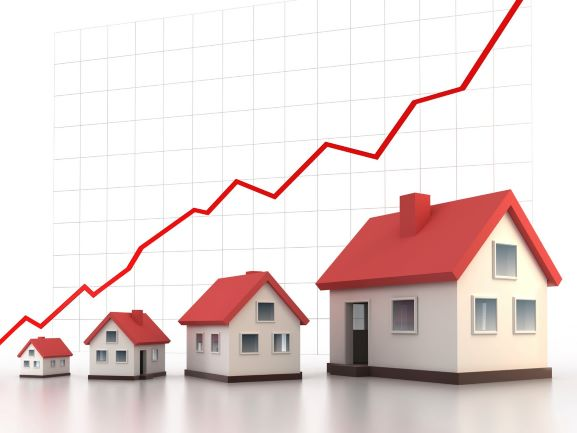

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Table of Content</p>

* [1. Data Exploration 📊](#1)
* [2. Data cleaning 🔧](#2)
    * [2.1 Fix target](#2.1)
    * [2.2 Correct and complete](#2.2)
    * [2.3 Creating new variables](#2.3)
    * [2.4 Transform existing variables](#2.4)
* [3. Feature Engineering ⚙️](#3)
    * [3.1 Feature encoding](#3.1)
* [4. Modeling: H2O 🏂](#4)
    * [4.1 H2O AutoML 📝](#4.1)
* [5. Submission 📝](#5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Data Exploration</p>

In [ ]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train_df.shape, test_df.shape

In [ ]:
house_price_profile = ProfileReport(train_df)

In [ ]:
house_price_profile

Lets look at the target variable and distribution!

In [ ]:
# I want to thanks @masumrumi for sharing this amazing plot!
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

In [ ]:
train_corr = train_df.drop('Id', axis=1).corr()

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(train_corr, dtype=np.bool))
# adjust mask and df
corr = train_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(train_corr, mask=mask, annot=False, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

Lets see how the Target var is related with other vars

In [ ]:
data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train_df['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
data = pd.concat([train_df['SalePrice'], train_df['TotalBsmtSF']], axis=1)
fig = px.scatter(data, x='TotalBsmtSF', y='SalePrice')
fig.show()

In [ ]:
data = pd.concat([train_df['SalePrice'], train_df['GrLivArea']], axis=1)
fig = px.scatter(data, x='GrLivArea', y='SalePrice')
fig.show()

In [ ]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_id = train_df['Id']
test_id = test_df['Id']

train_df = train_df.drop(['Id'], axis=1)
test_df = test_df.drop(['Id'], axis=1)

train_df.shape, test_df.shape

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Data cleaning</p>

In this stage, we will clean our data by 1) correcting aberrant values and outliers, 2) completing missing information, 3) creating new features for analysis, and 4) converting fields to the correct format for calculations and presentation.

1. **Correcting:** Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs. In addition, we see we may have potential outliers in age and fare. However, since they are reasonable values, we will wait until after we complete our exploratory analysis to determine if we should include or exclude from the dataset. It should be noted, that if they were unreasonable values, for example age = 800 instead of 80, then it's probably a safe decision to fix now. However, we want to use caution when we modify data from its original value, because it may be necessary to create an accurate model.
2. **Completing:** There are null values or missing data in the age, cabin, and embarked field. Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values. Thus, it's important to fix before we start modeling, because we will compare and contrast several models. There are two common methods, either delete the record or populate the missing value using a reasonable input. It is not recommended to delete the record, especially a large percentage of records, unless it truly represents an incomplete record. Instead, it's best to impute missing values. A basic methodology for qualitative data is impute using mode. A basic methodology for quantitative data is impute using mean, median, or mean + randomized standard deviation. An intermediate methodology is to use the basic methodology based on specific criteria; like the average age by class or embark port by fare and SES. There are more complex methodologies, however before deploying, it should be compared to the base model to determine if complexity truly adds value. For this dataset, age will be imputed with the median, the cabin attribute will be dropped, and embark will be imputed with mode. Subsequent model iterations may modify this decision to determine if it improves the model’s accuracy.
3. **Creating:**  Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. For this dataset, we will create a title feature to determine if it played a role in survival.
4. **Converting:** Last, but certainly not least, we'll deal with formatting. There are no date or currency formats, but datatype formats. Our categorical data imported as objects, which makes it difficult for mathematical calculations. For this dataset, we will convert object datatypes to categorical dummy variables.

In [ ]:
# Remove outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4500) & (train_df['SalePrice']<300000)].index)
train_df.shape

In [ ]:
# Split features and labels
y = train_df['SalePrice'].reset_index(drop=True)
train_features = train_df.drop('SalePrice', axis=1)
test_features = test_df.copy()

features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

In [ ]:
# Some of the non-numeric predictors are stored as numbers (based on description); convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['MoSold'] = features['MoSold'].astype(str)

<a id='2.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2.1 Fix target</p>

In [ ]:
plotting_3_chart(pd.DataFrame(y), 'SalePrice')

In [ ]:
# Fix the target variable
y = np.log1p(y)

plotting_3_chart(pd.DataFrame(y), 'SalePrice')

In [ ]:
y.head()

<a id='2.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2.2 Correct and Complete</p>

In [ ]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = ((features.isnull().sum() / features.isnull().count()) * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data.reset_index()
missing_data.columns = ['Name', 'Total', 'Percent']
missing_data[:10]

As we can see, we have there are **34** columns with some missing values, and **4** of them are over 80% missings!

So we are going to delete them!


In [ ]:
def handle_missing(features):
    # Deleting vars with high missings (over 80%)
    features = features.drop(features.loc[:, (features.isna().sum() / features.count()) > 0.8].columns, axis=1)
    
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    
    # Based on the type of dwelling, we can obtain the type of 'MSZoning'
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    # Finding all the categorical columns from the data
    categorical_columns = features.select_dtypes(exclude=['int64','float64']).columns
    numerical_columns = features.select_dtypes(include=['int64','float64']).columns

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    features[categorical_columns] = features[categorical_columns].fillna('None')
        
    # And we do the same thing for numerical features, but this time with 0s
    features[numerical_columns] = features[numerical_columns].fillna(0)
    
    return features

In [ ]:
features = handle_missing(features)
features.shape

In [ ]:
# check there are no nulls
features.isna().sum().sum()

Now data is cleaned and we can start the next step in feature engineering.

<a id='2.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2.3 Creating new variables</p>

In [ ]:
def add_new_vars(features):
    # simplified features
    features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    # Adding total sqfootage features 
    features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'])

    # Add years scince remodel
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)

    return features

In [ ]:
features = add_new_vars(features)
features.shape

<a id='2.4'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">2.4 Transform existing variables</p>

First, lets check the skew of the numeric variables

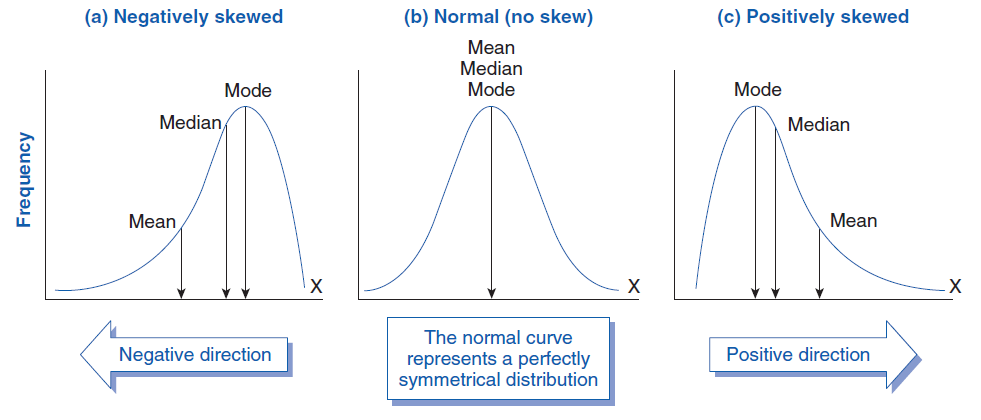

Few important things to know about **skew**:
- Skewness is the degree of distortion from the symmetrical bell curve or the normal distribution.
- Symmetrical distribution must have a skewness of 0.
- Skewness can be positive or negative.
- Skewness means that the mean and median are greater or lower than the mode.

In [ ]:
numerical_columns = features.select_dtypes(include=['int64','float64']).columns

skewed_features = features[numerical_columns].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew value' :skewed_features})
skewness.head(10)

In [ ]:
def fix_skew(features):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(include=['int64','float64']).columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [ ]:
features = fix_skew(features)
features.head()

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Feature Engineering</p>

In this section we are going to engineer the viariables to improve the performance.

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">3.1 Feature encoding</p>

For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.

In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

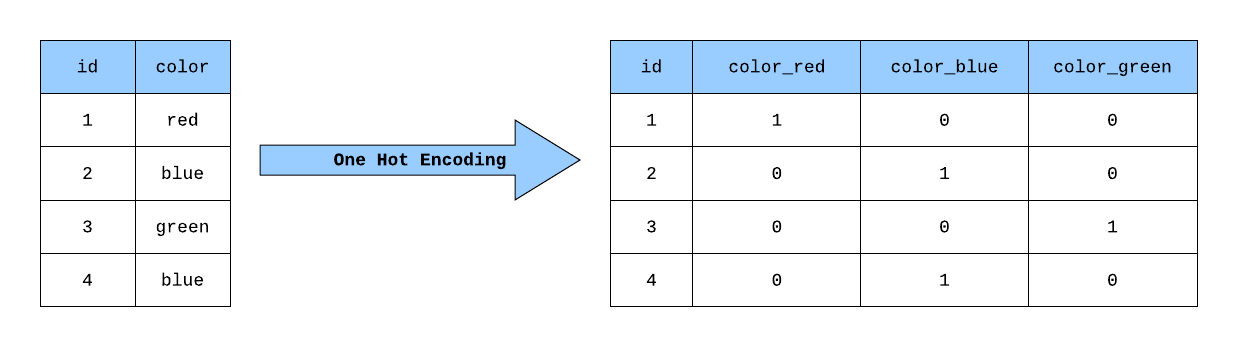

In [ ]:
features = pd.get_dummies(features).reset_index(drop=True)
features.shape

### Recreating train and test sets

In [ ]:
x = features.iloc[:len(y), :]
x_test = features.iloc[len(y):, :]
x.shape, y.shape, x_test.shape

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Modeling</p>

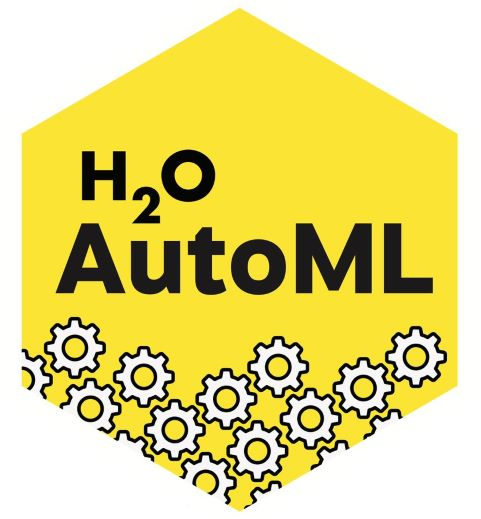

Ref: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles – one based on all previously trained models, another one on the best model of each family – will be automatically trained on collections of individual models to produce highly predictive ensemble models which, in most cases, will be the top performing models in the AutoML Leaderboard.

H2O offers a number of model explainability methods that apply to AutoML objects (groups of models), as well as individual models (e.g. leader model). Explanations can be generated automatically with a single function call, providing a simple interface to exploring and explaining the AutoML models.

### Required Stopping Parameters

One of the following stopping strategies (time or number-of-model based) must be specified. When both options are set, then the AutoML run will stop as soon as it hits one of either of these limits.

* **max_runtime_secs**: This argument specifies the maximum time that the AutoML process will run for, prior to training the final Stacked Ensemble models. The default is 0 (no limit), but dynamically sets to 1 hour if none of `max_runtime_secs` and `max_models` are specified by the user.

* **max_models**: Specify the maximum number of models to build in an AutoML run, excluding the Stacked Ensemble models. Defaults to `NULL/None`.

In [ ]:
import h2o

h2o.init()

In [ ]:
hf = h2o.H2OFrame(pd.concat([x, y], axis=1))
x_test_hf = h2o.H2OFrame(x_test)
hf.head()

In [ ]:
predictors = hf.drop('SalePrice').columns
response = 'SalePrice'

In [ ]:
# Split into train and test
train, valid = hf.split_frame(ratios=[.8], seed=1234)

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">4.1 H2O AutoML</p>

In [ ]:
from h2o.automl import H2OAutoML

# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1234,
    # exclude_algos = ["DeepLearning"]
)

In [ ]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=hf,
        # validation_frame=valid
)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=10)  # Print the first 5 rows

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Submission</p>

In [ ]:
submission_results = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [ ]:
predict = aml.predict(x_test_hf)
predict = predict.as_data_frame()
predict.head()

In [ ]:
submission_results.iloc[:, 1] = np.floor(np.expm1(predict['predict']))

# Fix outleir predictions
q_low = submission_results['SalePrice'].quantile(0.0045)
q_high = submission_results['SalePrice'].quantile(0.99)
submission_results['SalePrice'] = submission_results['SalePrice'].apply(lambda x: x if x > q_low else x*0.77)
submission_results['SalePrice'] = submission_results['SalePrice'].apply(lambda x: x if x < q_high else x*1.1)

submission_results.head()

In [ ]:
submission_results.to_csv('submission_results', index=False)